In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from collections import Counter
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")

### Helper functions

In [19]:
def load_and_prepare_data(mutation_data, disease_data):
    mutation_data["disease_name"] = mutation_data["case"].map(
        disease_data.set_index("case_id")["tumor_code"]
    )
    mutation_data = mutation_data.dropna(subset=["disease_name"])
    mutation_data = mutation_data.drop(columns=["case"])

    X = mutation_data.drop(columns=["disease_name"])
    X.dropna(axis=1, inplace=True)
    X = X.drop("worst_class_overall", axis=1, errors="ignore")

    y = mutation_data["disease_name"].astype("category")
    y_encoded = y.cat.codes
    class_labels = y.cat.categories.tolist()
    return X, y_encoded, class_labels


def calculate_scale_pos_weight(y_train):
    counter = Counter(y_train)
    neg_count = counter[0]
    pos_count = counter[1]

    scale_pos_weight = neg_count / pos_count

    print(f"Class distribution: {counter}")
    print(f"scale_pos_weight = {neg_count}/{pos_count} = {scale_pos_weight:.3f}")

    return scale_pos_weight

def train_model(X, y, class_labels, test_size=0.2, use_bayesian=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    scale_pos_weight = calculate_scale_pos_weight(y_train)

    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "min_child_weight": [1, 5],
        "gamma": [0, 0.2],
        "reg_alpha": [0, 0.1],
        "reg_lambda": [1, 2],
    }

    xgb = XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42,
    )

    if use_bayesian:
        search_spaces = {
            "n_estimators": (100, 200),
            "max_depth": (3, 5),
            "learning_rate": (0.01, 0.1, "log-uniform"),
            "subsample": (0.8, 1.0),
            "colsample_bytree": (0.8, 1.0),
            "min_child_weight": (1, 5),
            "gamma": (0, 0.2),
            "reg_alpha": (0, 0.1),
            "reg_lambda": (1, 2),
        }
        search = BayesSearchCV(
            xgb,
            search_spaces,
            cv=5,
            n_jobs=-1,
            scoring="accuracy",
            verbose=1,
            n_iter=20,
            random_state=42,
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        grid_search = search
    else:
        grid_search = GridSearchCV(
            xgb, param_grid, cv=5, n_jobs=-1, scoring="accuracy", verbose=1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

    return {
        "model": best_model,
        "X_test_selected": X_test,
        "y_test": y_test,
        "selected_feature_names": X_train.columns,
        "selector": None,
        "X_train_selected": X_train,
        "y_train": y_train,
        "grid_search": grid_search,
    }


def print_metrics(model, X_test_selected, y_test, grid_search):
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


def plot_confusion_matrix(model, X_test_selected, y_test, class_labels):
    short_labels = ['ALL', 'AML']
    plt.figure(figsize=(6, 5))
    ConfusionMatrixDisplay.from_estimator(
        model, X_test_selected, y_test, display_labels=short_labels, cmap="Blues"
    )
    plt.title("Confusion Matrix - XGBoost")
    plt.show()


def plot_feature_importance(model, feature_names, outdir="visualizations", top_n=15):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print("\nTop features:")
    print(feat_imp.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=feat_imp.head(top_n).values, y=feat_imp.head(top_n).index, palette="plasma"
    )
    plt.title(f"Top {top_n} Feature Importances - XGBoost")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(model, X_test_selected, y_test, class_labels):
    if len(class_labels) == 2:
        y_prob = model.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(
            fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="darkorange"
        )
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("ROC Curve - XGBoost")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

def cross_validate_model(model, X, y, k=5):
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"\n{k}-Fold Cross-Validation Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    return scores


def explain_model_with_shap(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    plt.figure()
    shap.plots.beeswarm(shap_values, max_display=15, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()

In [33]:
mutation_data = pd.read_csv("combined_mutation_matrix.csv")
mutation_data = mutation_data.dropna(axis=1, how='any')
disease_data = pd.read_csv("disease_ids.csv")

X, y, class_labels = load_and_prepare_data(mutation_data, disease_data)
X.head()

,t_alt_AASDH,t_alt_ABCA1,t_alt_ABCA13,t_alt_ABCA5,t_alt_ABCA6,t_alt_ABCC1,t_alt_ACADL,t_alt_ACTC1,t_alt_ADAMTS18,t_alt_ADAMTS19,...,mean_vaf_ZFR2,mean_vaf_ZNF415,mean_vaf_ZNF462,mean_vaf_ZNF469,mean_vaf_ZNF516,mean_vaf_ZNF518A,mean_vaf_ZNF521,mean_vaf_ZNF57,mean_vaf_ZNF618,mean_vaf_ZNF804B
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selected Model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
print_metrics(xgb, X_test, y_test, None)

Accuracy: 0.8571428571428571

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       243
           1       0.88      0.84      0.86       254

    accuracy                           0.86       497
   macro avg       0.86      0.86      0.86       497
weighted avg       0.86      0.86      0.86       497



## GridSearch Model

In [46]:
model_info = train_model(X, y, class_labels)

print("Best parameters from GridSearchCV:", model_info["grid_search"].best_params_)
print_metrics(
    model_info["model"],
    model_info["X_test_selected"],
    model_info["y_test"],
    model_info["grid_search"],
)

Class distribution: Counter({1: 677, 0: 647})
scale_pos_weight = 647/677 = 0.956
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


C:\Users\dolke\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 1.0}
Accuracy: 0.8554216867469879

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       162
           1       0.91      0.80      0.85       170

    accuracy                           0.86       332
   macro avg       0.86      0.86      0.86       332
weighted avg       0.86      0.86      0.86       332



<Figure size 600x500 with 0 Axes>

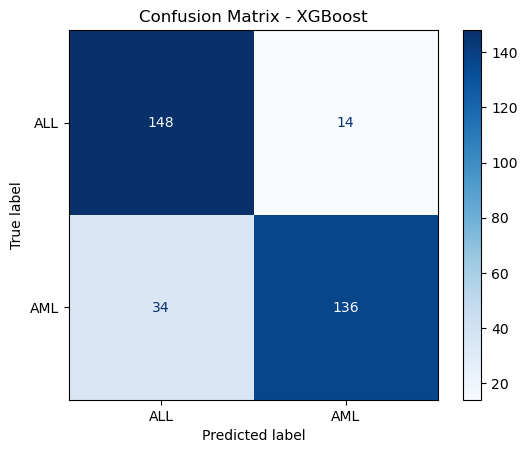

In [54]:
plot_confusion_matrix(
    model_info["model"],
    model_info["X_test_selected"],
    model_info["y_test"],
    class_labels,
)


Top features:
t_alt_NOTCH1       0.099857
mean_vaf_NOTCH1    0.065078
t_alt_NPM1         0.051068
t_alt_KIT          0.038698
mean_vaf_CEBPA     0.037430
t_alt_TTN          0.028066
t_alt_PAX5         0.025121
t_alt_CNTNAP2      0.024354
t_alt_DST          0.023476
t_alt_DNMT3A       0.022643
dtype: float32


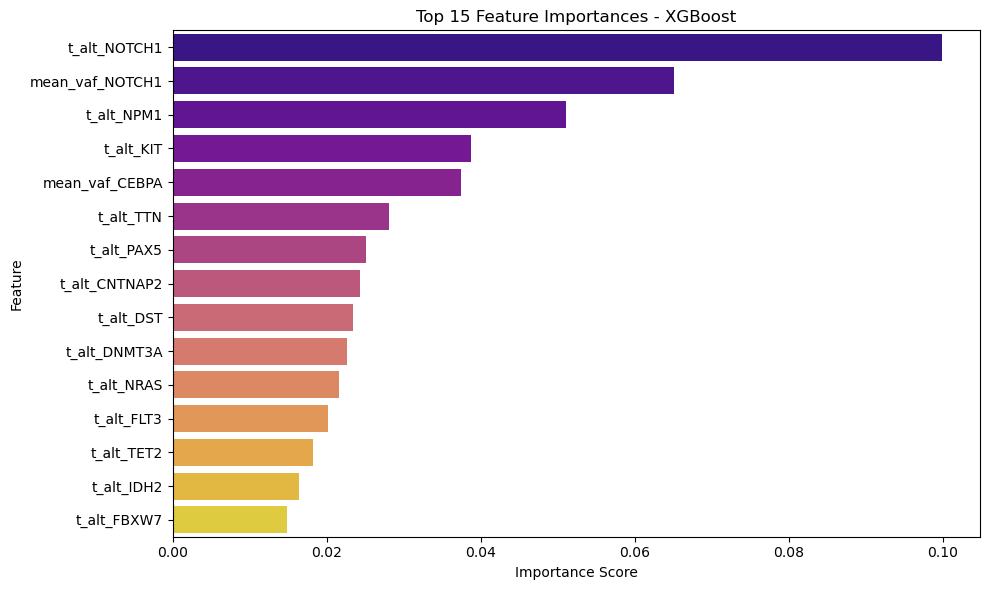

In [56]:
plot_feature_importance(model_info["model"], model_info["selected_feature_names"])

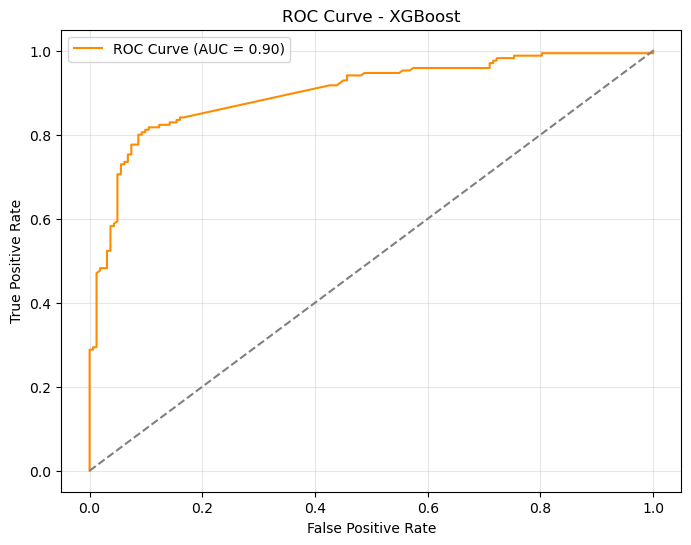

In [58]:
plot_roc_curve(
    model_info["model"],
    model_info["X_test_selected"],
    model_info["y_test"],
    class_labels,
)

In [60]:
cross_validate_model(model_info["model"], X, y, k=5)


5-Fold Cross-Validation Accuracy Scores: [0.89457831 0.90030211 0.85800604 0.83081571 0.86102719]
Mean Accuracy: 0.8689 (+/- 0.0256)


array([0.89457831, 0.90030211, 0.85800604, 0.83081571, 0.86102719])

## Bayesian Search

In [73]:
model_info = train_model(X, y, class_labels, use_bayesian=True)

print("Best parameters from Bayesian:", model_info["grid_search"].best_params_)
print_metrics(
    model_info["model"],
    model_info["X_test_selected"],
    model_info["y_test"],
    model_info["grid_search"],
)

Class distribution: Counter({1: 677, 0: 647})
scale_pos_weight = 647/677 = 0.956
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 cand

<Figure size 600x500 with 0 Axes>

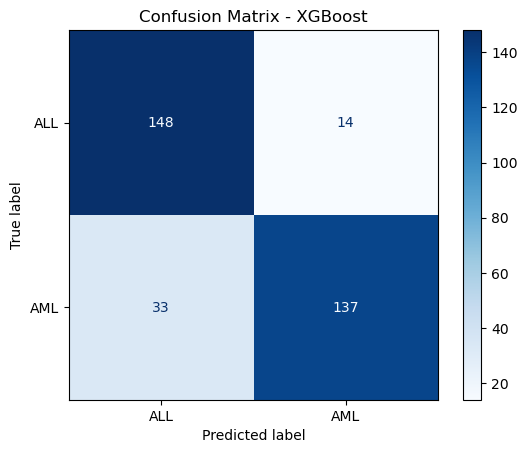

In [64]:
plot_confusion_matrix(
    model_info["model"],
    model_info["X_test_selected"],
    model_info["y_test"],
    class_labels,
)


Top features:
t_alt_NOTCH1       0.071545
mean_vaf_NOTCH1    0.059794
t_alt_NPM1         0.046655
t_alt_KIT          0.033689
mean_vaf_CEBPA     0.029146
t_alt_TTN          0.024998
t_alt_DST          0.024758
t_alt_CNTNAP2      0.023137
t_alt_PAX5         0.022580
t_alt_NRAS         0.021673
dtype: float32


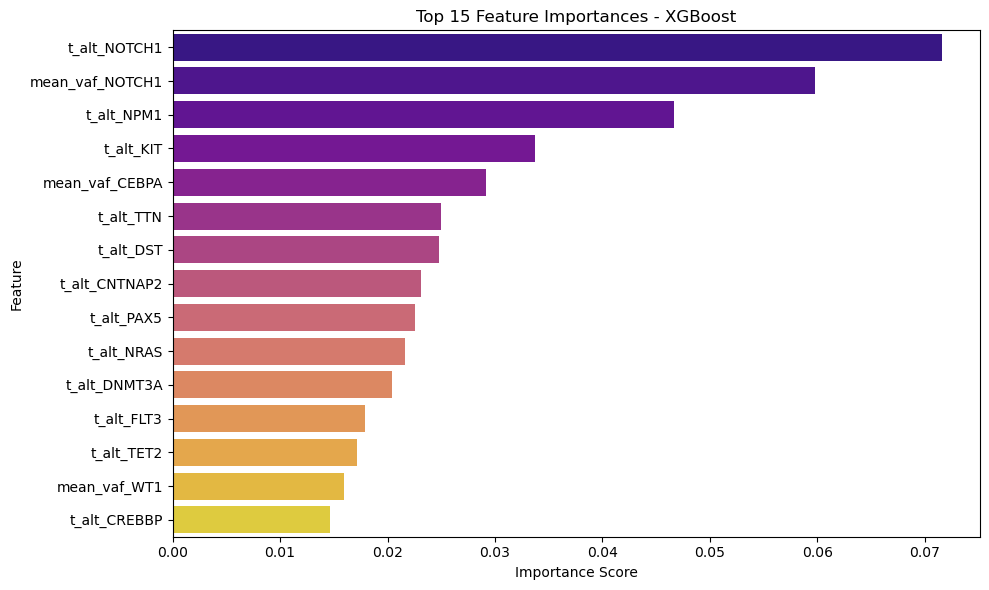

In [66]:
plot_feature_importance(model_info["model"], model_info["selected_feature_names"])

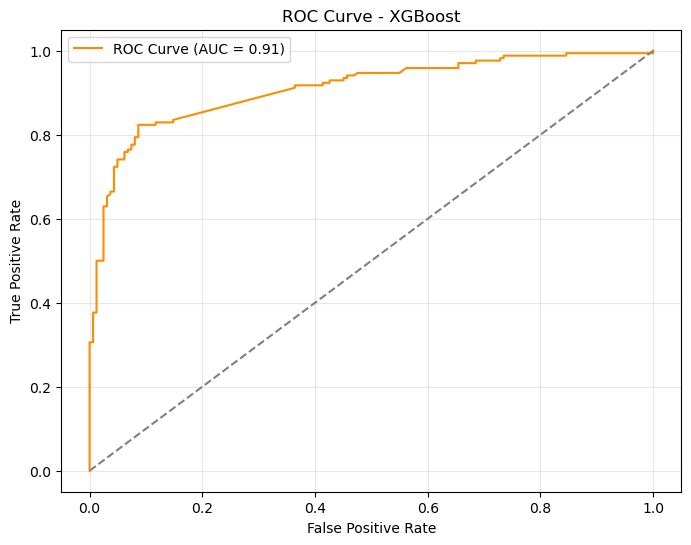

In [68]:
plot_roc_curve(
    model_info["model"],
    model_info["X_test_selected"],
    model_info["y_test"],
    class_labels,
)

In [70]:
cross_validate_model(model_info["model"], X, y, k=5)


5-Fold Cross-Validation Accuracy Scores: [0.89457831 0.90332326 0.86102719 0.83987915 0.86102719]
Mean Accuracy: 0.8720 (+/- 0.0235)


array([0.89457831, 0.90332326, 0.86102719, 0.83987915, 0.86102719])